<a href="https://colab.research.google.com/github/kellyslpang/unpackAIworkbooks/blob/main/Kelly_08_collab_own_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering - Own Code

Refactored code and notes from `08_collab.ipynb`.

## Refactor end to end collaborative filtering

Rewrite the code to create a Collaborative Filtering model on the same *MovieLens* dataset as in the Chapter 8 notebook, but with only the code necessary to load the dataset, create the DataLoaders and the model, and run it. Also add any code you personally consider important for you to understand what you are doing or verify/test things. Add you onw comment and references for your future self when you are comng back to this book.

### Imports and setup

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 35.9 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 188 kB 37.5 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 51 kB 249 kB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *

### Loading the dataset

In [4]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [5]:
[p.name for p in path.ls() if 'READ' in p.name or 'read' in p.name]

['README']

In [6]:
with open(path/'README', 'r') as f:
    print(f.read())

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Creating the DataLoaders

In [6]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [9]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [10]:
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

### Creating your model with fastai

In [11]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [12]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.958137,0.954001,00:12
1,0.872298,0.875933,00:12
2,0.745986,0.838503,00:12
3,0.600054,0.821116,00:12
4,0.484811,0.821436,00:12


### Interpreting the results

In [13]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

#### Rank movies using movie biases

In [17]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Jerry Maguire (1996)',
 'Second Jungle Book: Mowgli & Baloo, The (1997)',
 'My Left Foot (1989)',
 'Gigi (1958)',
 'Fan, The (1996)']

#### Find movie that are similar to another movie

In [18]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Tainted (1998)'

## Create a new model, using deep learning instead of PMF
Code above used *probabilistic matrix factorization (PMF)*. Following cells make a new model for the deep learning version.

In [14]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.983549,1.013847,00:17
1,0.922063,0.914028,00:17
2,0.880137,0.887165,00:16
3,0.811694,0.860861,00:16
4,0.755774,0.866455,00:16


In [15]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

#### Find movie that are similar to another movie (using deep learning version)

In [33]:
movie_title = 'Gone with the Wind (1939))'
movie_title = 'Wizard of Oz, The (1939))'
movie_title = 'Jaws (1975)'
movie_title = 'Godfather, The (1972)'
movie_title = 'GoodFellas (1990)'
n = 5

#movie_factors = learn.model.i_weight.weight
movie_factors = learn.model.embeds[1].weight[1:]
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Maverick (1994)',
 'Browning Version, The (1994)',
 'In the Company of Men (1997)',
 'Gumby: The Movie (1995)',
 'Butcher Boy, The (1998)']

## Assignment 2: Run additional code

In [34]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [35]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [36]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [37]:
dls.classes['title'][3]

'101 Dalmatians (1996)'

In [38]:
dls.classes['title'].o2i['101 Dalmatians (1996)']

3

In [40]:
m_list = [619, 774, 613, 624]
for m in m_list:
    print(dls.classes['title'][m])

Gone with the Wind (1939)
Jaws (1975)
Godfather, The (1972)
GoodFellas (1990)


In [41]:
dls.classes['title'].o2i['Gone with the Wind (1939)']

619

In [42]:
learn.i_weight.weight

Parameter containing:
tensor([[ 0.0009, -0.0029,  0.0024,  ..., -0.0068, -0.0193, -0.0090],
        [-0.0024,  0.0073,  0.0014,  ..., -0.0021, -0.0004,  0.0022],
        [ 0.0087,  0.0057, -0.0091,  ...,  0.0084,  0.0029,  0.0066],
        ...,
        [-0.0142, -0.0048, -0.0005,  ..., -0.0123, -0.0097, -0.0023],
        [-0.0131, -0.0030, -0.0091,  ..., -0.0074,  0.0099, -0.0150],
        [-0.0089,  0.0050,  0.0044,  ..., -0.0051,  0.0172, -0.0119]], requires_grad=True)

In [43]:
idxs = [619]
print(f"Latent Factors for: {dls.classes['title'][idxs]}")
learn.u_weight.weight[idxs]

Latent Factors for: ['Gone with the Wind (1939)']


tensor([[-0.0130,  0.0127,  0.0098,  0.0092, -0.0084, -0.0150, -0.0054,  0.0048, -0.0030, -0.0082,  0.0080,  0.0175, -0.0090,  0.0047, -0.0076,  0.0125, -0.0044,  0.0113,  0.0173, -0.0099, -0.0060,
          0.0062, -0.0039, -0.0052,  0.0074, -0.0021, -0.0001, -0.0017, -0.0132,  0.0055, -0.0007,  0.0088,  0.0158, -0.0149, -0.0050,  0.0061, -0.0023,  0.0075,  0.0186, -0.0136,  0.0094,  0.0067,
         -0.0058, -0.0089,  0.0157,  0.0007, -0.0084,  0.0084, -0.0007, -0.0113]], grad_fn=<IndexBackward>)

In [44]:
idxs = [619, 774, 613, 624]
print(f"Latent Factors for: {dls.classes['title'][idxs]}\n")
learn.u_weight.weight[idxs]

Latent Factors for: ['Gone with the Wind (1939)', 'Jaws (1975)', 'Godfather, The (1972)', 'GoodFellas (1990)']



tensor([[-1.3009e-02,  1.2717e-02,  9.7870e-03,  9.2438e-03, -8.3785e-03, -1.4993e-02, -5.4488e-03,  4.7899e-03, -2.9936e-03, -8.1741e-03,  7.9692e-03,  1.7497e-02, -8.9703e-03,  4.7035e-03,
         -7.5710e-03,  1.2518e-02, -4.4257e-03,  1.1344e-02,  1.7285e-02, -9.9381e-03, -5.9933e-03,  6.1918e-03, -3.8937e-03, -5.2289e-03,  7.4137e-03, -2.1276e-03, -1.4904e-04, -1.7383e-03,
         -1.3188e-02,  5.5435e-03, -7.0910e-04,  8.7661e-03,  1.5834e-02, -1.4899e-02, -4.9818e-03,  6.1493e-03, -2.2691e-03,  7.5359e-03,  1.8617e-02, -1.3592e-02,  9.3580e-03,  6.6700e-03,
         -5.7783e-03, -8.8838e-03,  1.5738e-02,  6.9665e-04, -8.3904e-03,  8.4245e-03, -6.6065e-04, -1.1331e-02],
        [-6.3080e-03,  1.6386e-03, -1.4072e-02, -5.7979e-03, -3.6936e-03, -6.5473e-03, -5.4158e-03, -9.5243e-03, -9.5632e-03, -4.9164e-04, -2.6772e-03,  8.6573e-03, -9.5012e-04,  7.2091e-03,
          8.3725e-03,  7.2030e-03,  1.0421e-02,  1.8228e-03, -3.5216e-03, -5.6742e-03,  3.3183e-03, -6.9078e-03,  1.2586e-

In [45]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.960574,0.933064,00:09
1,0.882286,0.871205,00:09
2,0.722912,0.830554,00:09
3,0.596436,0.816410,00:09
4,0.491007,0.815917,00:09


In [46]:
idxs = [1, 10, 56, 106]
print(f"Latent Factors for user with ID: {dls.classes['user'][idxs]}\n")
learn.u_weight.weight[idxs]

Latent Factors for user with ID: [1, 10, 56, 106]



tensor([[-3.2775e-01, -2.5062e-01,  1.5241e-01, -2.7292e-01,  3.1780e-01, -2.9879e-01, -1.5508e-02, -1.4472e-01, -4.2995e-03, -1.7490e-01,  2.5983e-02, -2.5725e-01, -7.2333e-02,  1.0219e-01,
          2.0275e-01,  1.6179e-01,  4.2368e-01,  2.5488e-01, -9.0259e-03,  7.4800e-02, -8.3603e-02,  1.2413e-01, -2.9178e-01, -1.3720e-01,  2.7458e-01, -2.7954e-01,  1.6140e-01,  2.0258e-01,
          4.8997e-01,  9.6551e-02, -4.5924e-01,  9.4455e-02, -2.6996e-01,  2.2307e-01, -3.1040e-01,  9.0030e-02,  1.8781e-01,  2.4568e-01,  2.1315e-01,  1.2131e-01,  3.7777e-01, -2.1242e-01,
         -1.8016e-01,  2.5180e-01,  6.6893e-02, -8.7576e-02,  1.8026e-01, -2.6464e-01,  1.0135e-01,  1.4326e-01],
        [-1.1492e-02, -1.6746e-01,  4.5312e-02, -9.5799e-02, -2.5317e-01, -1.1725e-01, -2.5716e-01, -1.2048e-01,  1.4865e-01, -1.1473e-01,  1.2156e-01, -1.4465e-01, -1.0315e-01,  1.9661e-01,
         -1.3392e-01,  6.7778e-04, -1.3988e-02,  1.7110e-01,  1.6957e-01, -1.6737e-01,  5.8463e-02,  1.5940e-01, -1.8460e-

In [47]:
idxs = [619, 774, 613, 624]
print(f"Latent Factors for: {dls.classes['title'][idxs]}\n")
learn.i_weight.weight[idxs]

Latent Factors for: ['Gone with the Wind (1939)', 'Jaws (1975)', 'Godfather, The (1972)', 'GoodFellas (1990)']



tensor([[-6.4507e-02, -8.4732e-02, -1.0416e-01, -1.8350e-01, -2.8505e-01, -1.0845e-01, -2.9165e-01, -3.0505e-01,  4.4793e-01, -4.1733e-01, -2.3223e-01, -9.0442e-02, -2.0605e-01,  3.7760e-02,
         -6.0323e-02,  2.0008e-01, -3.7539e-02,  2.2966e-01,  1.0380e-01, -2.9462e-01,  7.4024e-02, -6.4985e-05, -4.0297e-01,  9.0443e-03, -1.3410e-02, -4.5124e-02,  2.2335e-01, -4.6634e-02,
         -1.3611e-01, -3.4589e-01, -1.2513e-01,  2.8793e-01,  1.2992e-01, -1.0323e-01,  1.1229e-01,  7.1917e-02, -5.7088e-02,  1.1582e-01,  8.1915e-02,  9.4762e-02, -8.5692e-02, -4.0256e-01,
         -1.0439e-01, -6.7965e-02,  1.9540e-02, -1.2520e-01,  2.7946e-01, -2.8348e-01,  1.4729e-01,  6.2405e-02],
        [ 4.6425e-02, -1.0073e-01,  5.2835e-02, -1.1919e-01,  1.5208e-01,  5.5885e-02, -2.8617e-01, -1.1034e-01, -6.7222e-02, -1.7155e-01,  4.1074e-02, -1.4354e-01, -8.5883e-02,  3.5331e-01,
          2.3137e-01,  3.4908e-01,  9.1294e-02,  1.7251e-01,  1.3706e-01, -2.7822e-01, -1.2169e-01,  1.5200e-01, -8.7299e-

In [52]:
movie_title = 'Jaws (1975)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Line King: Al Hirschfeld, The (1996)',
 'Everest (1998)',
 "One Flew Over the Cuckoo's Nest (1975)",
 'Patton (1970)',
 'Pinocchio (1940)']

In [ ]:
some 70s movies....  natural disaster

In [51]:
movie_title = 'Jurassic Park (1993)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Braveheart (1995)',
 'Fugitive, The (1993)',
 'Back to the Future (1985)',
 'Twister (1996)',
 'Titanic (1997)']

Action type movies. Some sci-fi.

In [53]:
movie_title = 'Indiana Jones and the Last Crusade (1989)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Raiders of the Lost Ark (1981)',
 'Terminator 2: Judgment Day (1991)',
 'Back to the Future (1985)',
 'Stripes (1981)',
 'Empire Strikes Back, The (1980)']

In [ ]:
action/adventure, sci-fi

In [54]:
movie_title = 'Don Juan DeMarco (1995)'
n = 5

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i[movie_title]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])

idx = distances.argsort(descending=True)[1:n+1]
list(dls.classes['title'][idx])

['Waiting for Guffman (1996)',
 'Meet John Doe (1941)',
 'Thieves (Voleurs, Les) (1996)',
 'Lost Horizon (1937)',
 'Star Kid (1997)']

In [ ]:
dls.classes['title'].o2i

In [55]:
# Create the Collab Filtering model

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

epoch,train_loss,valid_loss,time
0,0.949852,0.923733,00:09
1,0.823852,0.850528,00:09
2,0.597979,0.861329,00:09
3,0.386285,0.890368,00:09
4,0.262233,0.897335,00:09


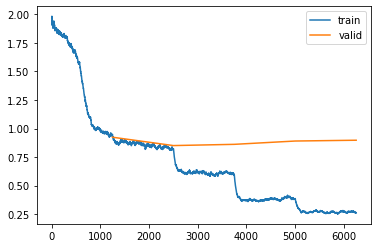

In [56]:
wd_test = 0.0
lr = 5e-3
epochs = 5

set_seed(1988, reproducible=True)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
model = DotProductBias(n_users, n_movies, 50)
learn_no_wd = Learner(dls, model, loss_func=MSELossFlat())
learn_no_wd.fit_one_cycle(epochs, lr, wd=wd_test)
learn_no_wd.recorder.plot_loss()

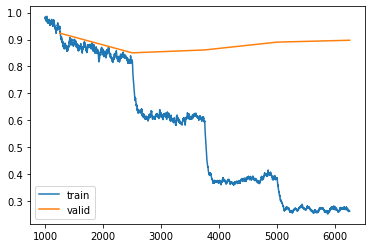

In [57]:
learn_no_wd.recorder.plot_loss(skip_start=1000)

overfitting - step drops - complex polynomial

epoch,train_loss,valid_loss,time
0,0.960804,0.933810,00:09
1,0.854080,0.862984,00:09
2,0.728801,0.825311,00:09
3,0.593453,0.813169,00:09
4,0.482809,0.813137,00:09


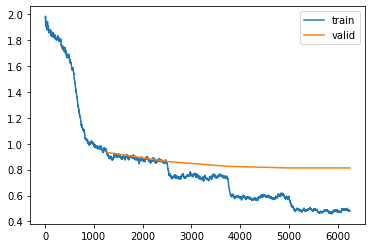

In [58]:
wd_test = 0.1
lr = 5e-3
epochs = 5

set_seed(1988, reproducible=True)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
model = DotProductBias(n_users, n_movies, 50)
learn_typical_wd = Learner(dls, model, loss_func=MSELossFlat())
learn_typical_wd.fit_one_cycle(epochs, lr, wd=wd_test)
learn_typical_wd.recorder.plot_loss()

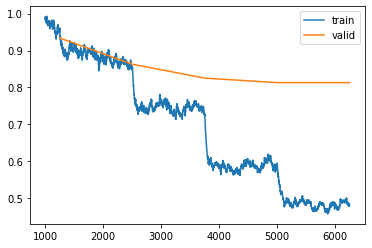

In [59]:
learn_typical_wd.recorder.plot_loss(skip_start=1000)

still overfits

epoch,train_loss,valid_loss,time
0,1.053355,1.029261,00:09
1,1.011941,1.015972,00:09
2,1.002579,0.993225,00:09
3,0.957208,0.963042,00:09
4,0.934998,0.953659,00:09


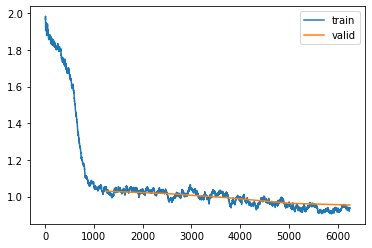

In [60]:
wd_test = 0.75
lr = 5e-3
epochs = 5

set_seed(1988, reproducible=True)

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
model = DotProductBias(n_users, n_movies, 50)
learn_big_wd = Learner(dls, model, loss_func=MSELossFlat())
learn_big_wd.fit_one_cycle(epochs, lr, wd=wd_test)
learn_big_wd.recorder.plot_loss()

In [ ]:
learn_big_wd.recorder.plot_loss(skip_start=1000)

## Assigment 3: Reflect on Questionnaire

1. **What problem does collaborative filtering solve?**
recommend which products are most likely to be useful for which users. 
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. **What is a latent factor? Why is it "latent"?**  variables that are not directly observed but are rather inferred. or found through some sort of algorithm
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. **What is an embedding matrix?**capture relationships mathematically; a method used to represent discrete variables as continuous vectors. computation shortcut 
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. **What is a good loss function to use for MovieLens? Why? ** MSELossFlat
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. **What is the use of bias in a dot product model?** to capture whether a user likes the movie or not
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. **Why does reducing weights lead to better generalization?** prevents overfitting
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. **How could you deal with the bootstrapping problem for new users? For new movies?** variations of use your common sense: pick user to represent average taste OR ask user questions on sign-up to create initial embedding vector
1. How can feedback loops impact collaborative filtering systems?
1. **When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?** concatenating the embeddings, rather than taking their dot product, 
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?